# Load, clean, and display data

In [767]:
# !pip install arch             # uncomment for installing the arch package
import numpy as np
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

In [768]:
# Read data file

df = pd.read_excel('/Users/jinhyun/Documents/GitHub/Python/assignment/assignmentsmodelvalidatortradingriskmodelsating/1. IndexData.xls') # imports the data
display(df)

,Date,DAX,SMI
0,2007-03-30,6917.03,8976.99
1,2007-04-02,6937.17,8956.31
2,2007-04-03,7045.56,9053.95
3,2007-04-04,7073.91,9057.62
4,2007-04-05,7099.91,9099.08
...,...,...,...
780,2010-03-26,6120.05,6838.95
781,2010-03-29,6156.85,6850.58
782,2010-03-30,6142.45,6871.42
783,2010-03-31,6153.55,6873.37


Now we transform the data 

In [769]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d') # transform date strings to datetime 
df = df.set_index(['Date']) # set index of DataFrame to the date column

In [770]:
df['R_DAX'] = np.log(df[['DAX']]) - np.log(df[['DAX']]).shift(1) # calculate DAX returns
df['R_SMI'] = np.log(df[['SMI']]) - np.log(df[['SMI']]).shift(1) # calculate SMI returns
df = df.dropna() # drop N/A entries

R_DAX =  (df['R_DAX'])['2007-03-30':] # remove first row from returns 
R_SMI =  (df['R_SMI'])['2007-03-30':] 

df['DAX_eur'] =  df[['DAX']]*500 # find the value of indices
df['SMI_eur'] =  df[['SMI']]*450 

display(df)


,DAX,SMI,R_DAX,R_SMI,DAX_eur,SMI_eur
Date,,,,,,
2007-04-02,6937.17,8956.31,0.002907,-0.002306,3468585.0,4030339.5
2007-04-03,7045.56,9053.95,0.015504,0.010843,3522780.0,4074277.5
2007-04-04,7073.91,9057.62,0.004016,0.000405,3536955.0,4075929.0
2007-04-05,7099.91,9099.08,0.003669,0.004567,3549955.0,4094586.0
2007-04-06,7099.91,9099.08,0.000000,0.000000,3549955.0,4094586.0
...,...,...,...,...,...,...
2010-03-26,6120.05,6838.95,-0.002106,-0.008042,3060025.0,3077527.5
2010-03-29,6156.85,6850.58,0.005995,0.001699,3078425.0,3082761.0
2010-03-30,6142.45,6871.42,-0.002342,0.003037,3071225.0,3092139.0


Display a line graph of the returns,

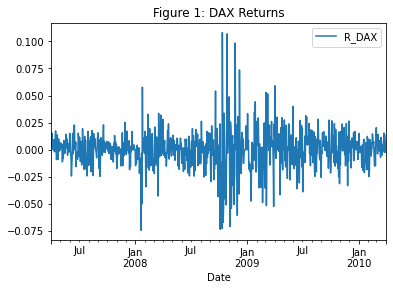

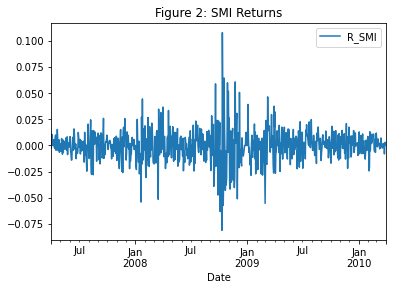

Skewness
DAX : 0.25802976832123947 / SMI: 0.18726592410554285
Kurtosis
DAX : 6.460467916791626 / SMI: 6.327211792289833


In [771]:
# line graph of the returns
R_DAX.plot()
plt.title('Figure 1: DAX Returns')
plt.legend(['R_DAX'])
plt.show()

R_SMI.plot()
plt.title('Figure 2: SMI Returns')
plt.legend(['R_SMI'])
plt.show()

# Calculate the skewness and kurtosis of the returns.

# returns the skewness of a series
print("Skewness")
print('DAX :', R_DAX .skew(),'/ SMI:',R_SMI.skew())

# returns the excess kurtosis of a series
print("Kurtosis")
print('DAX :',R_DAX.kurtosis() ,'/ SMI:',R_SMI.kurtosis()) 


a)	Estimate the 1-day 99% VaR of both portfolios (individually) on the situation date 1 April 2010 using the Normal VaR approach. 

In [772]:
# the pth quantile of the normal distribution 
p=0.01
pquantile_norm = stats.norm.ppf(p)


# Obtain the 'VaR forecasts' and compute the 'percentage of exceedences'. 
price_DAX = 500
price_SMI = 450

c_DAX = np.std(R_DAX) # a constantseries / cons_std = R*0 + c
c_SMI = np.std(R_SMI) 
VaR_forecast_norm_DAX = -price_DAX * c_DAX * stats.norm.ppf(p)
VaR_forecast_norm_SMI = -price_SMI * c_SMI *stats.norm.ppf(p)
print('DAX, 99% VaR (Normal distribution):', VaR_forecast_norm_DAX)
print('SMI, 99% VaR (Normal distribution):', VaR_forecast_norm_SMI)

hit_series_norm_DAX = np.where(R_DAX< -VaR_forecast_norm_DAX, 1, 0) # Create a hit series. 1: if R < -VaR_forecast
hit_series_norm_SMI = np.where(R_SMI< -VaR_forecast_norm_SMI, 1, 0)

per_exceed_norm_DAX = sum(hit_series_norm_DAX)/len(hit_series_norm_DAX)   # Calculate the percentage of exceedence.
per_exceed_norm_SMI = sum(hit_series_norm_SMI)/len(hit_series_norm_SMI)

print('DAX, Percentage of exceedence (Normal distribution):', str(round(per_exceed_norm_DAX*100,4)) +'%')
print('SMI, Percentage of exceedence (Normal distribution):', str(round(per_exceed_norm_SMI*100,4)) +'%')


DAX, 99% VaR (Normal distribution): 20.770983583520632
SMI, 99% VaR (Normal distribution): 16.11053885341144
DAX, Percentage of exceedence (Normal distribution): 0.0%
SMI, Percentage of exceedence (Normal distribution): 0.0%


b)	Explain if the assumption of normally distributed returns is valid. 

In [773]:
print('DAX :', stats.jarque_bera(R_DAX))
print('SMI :', stats.jarque_bera(R_SMI))

DAX : Jarque_beraResult(statistic=1351.5881129202228, pvalue=0.0)
SMI : Jarque_beraResult(statistic=1292.5938610563617, pvalue=0.0)


Jarque-Bera test is designed to test the normality (goodness of fit test). The test statistic for JB test with p = 99.5% is 10.597.
The actual result of the DAX return is larger than JB test statistic. (1345.2635 > 10.597)
The actual result of the SMI return is larger than JB test statistic. (1286.1795 > 10.597)
The p values from two types of returns are also significant (p < 0.01)
Therefore we can conclude that the assumption of normally distributed reuturn is not valid


c)	Estimate the 1-day 99% VaR for both portfolios (individually) on the situation date 1 April 2010 using the Historical Simulation approach. 

In [774]:
historic_var_DAX = np.percentile(R_DAX, 1, interpolation='lower')
historic_var_SMI = np.percentile(R_SMI, 1, interpolation='lower')

print(f'The historical DAX 99% VaR is {str(round(historic_var_DAX,4)*100)}%')
print(f'The historical SMI 99% VaR is {str(round(historic_var_SMI,4)*100)}%')

The historical DAX 99% VaR is -5.4%
The historical SMI 99% VaR is -5.1%


## 2 

a)	Estimate the 1-day 99% VaR of the consolidated portfolio for the situation date 1 April 2010 using the Normal Variance-Covariance VaR approach. 

In [775]:
# Declare Empty Lists
Mean = []
STD = []

#Calculate DEAR
ticker_R = ['R_DAX', 'R_SMI']
value = df[['DAX', 'SMI']].iloc[-1]

for i in range(2):
    v = np.std(df[ticker_R[i]])              # Standard Error
    mean = np.mean(df[ticker_R[i]])          # Mean 

    # Append those values in lists
    Mean.append(mean)
    STD.append(v)

In [776]:
# Construct new Table
dear = pd.DataFrame({'Mean': Mean, 'STD': STD}, index = ['R_DAX','R_SMI'])
display(dear)

,Mean,STD
R_DAX,-0.000132,0.017857
R_SMI,-0.000338,0.015389


In [777]:
# Correlation Coefficient
rho = df[['R_DAX','R_SMI']].corr() # find the correlation of two returns
display(rho)

# Instead of price data, we apply return data to get the correlation coefficient among stocks. 
# By doing so, we would avoid Spurious Regression and compute correct coefficient.


,R_DAX,R_SMI
R_DAX,1.000000,0.818536
R_SMI,0.818536,1.000000


In [778]:
# concatenate dear and rho
portfolio = pd.concat([dear, rho,], axis = 1) 
display(portfolio)

,Mean,STD,R_DAX,R_SMI
R_DAX,-0.000132,0.017857,1.000000,0.818536
R_SMI,-0.000338,0.015389,0.818536,1.000000


In [786]:
# calculate weights of each portfolio (based on latest figures)
w1 = df['DAX_eur'].iloc[-1]/(df['DAX_eur'].iloc[-1] + df['SMI_eur'].iloc[-1])
w2 = df['SMI_eur'].iloc[-1]/(df['DAX_eur'].iloc[-1] + df['SMI_eur'].iloc[-1])

# define variables
DAX_std = portfolio.at['R_DAX','STD'] # standard deviation
SMI_std = portfolio.at['R_SMI','STD']
corr = portfolio.at['R_DAX','R_SMI'] # correlation

# calculate the variance and volatility of the consolidated portfolio
var_port_consol = w1**2*DAX_std**2 + w2**2*SMI_std**2 + 2*(w1*w2*DAX_std*SMI_std*corr) # variance
vol_port_consol = var_port_consol**(1/2) # volatility


def rel_VaR(price1,weight1,price2,weight2,sigma,Quantile):
    """
    Relative VaR
    """
    return (price1*weight1 + price2*weight2) * sigma * stats.norm.ppf(Quantile)


print(f'Variance of consolidate portfolio is {str(round(var_port_consol,4))}')
print(f'Volatility of consolidate portfolio is {str(round(vol_port_consol,4))}')
print(f'99% relative VaR of consolidate portfolio is {str(round(rel_VaR(500,0.5,450,0.5,vol_port_consol,0.99),4))}%')


Variance of consolidate portfolio is 0.0003
Volatility of consolidate portfolio is 0.0159
99% relative VaR of consolidate portfolio is 17.5248%


Interpretation

According to above calculation, we conclude that maximum loss of the portfolio in one day would not exceed 394 thousands at 99 percent chance. However, market always fluctuates. Hence, keeping the calculation of VaR regularly would make our judgement more accurately.

b)	Estimate the 1-day 99% VaR of the consolidated portfolio for the situation date 1 April 2010 using the Historical Simulation approach. 

In [781]:
w1_DAX = df['DAX'].iloc[-1]/(df['DAX'].iloc[-1] + df['SMI'].iloc[-1]) # weight of DAX with latest figure
w1_SMI = df['SMI'].iloc[-1]/(df['DAX'].iloc[-1] + df['SMI'].iloc[-1])
price_port = w1_DAX*price_DAX + w1_SMI*price_SMI

df['R_portf'] = df['R_DAX'] + df['R_SMI']
df

,DAX,SMI,R_DAX,R_SMI,DAX_eur,SMI_eur,R_portf
Date,,,,,,,
2007-04-02,6937.17,8956.31,0.002907,-0.002306,3468585.0,4030339.5,0.000601
2007-04-03,7045.56,9053.95,0.015504,0.010843,3522780.0,4074277.5,0.026347
2007-04-04,7073.91,9057.62,0.004016,0.000405,3536955.0,4075929.0,0.004421
2007-04-05,7099.91,9099.08,0.003669,0.004567,3549955.0,4094586.0,0.008236
2007-04-06,7099.91,9099.08,0.000000,0.000000,3549955.0,4094586.0,0.000000
...,...,...,...,...,...,...,...
2010-03-26,6120.05,6838.95,-0.002106,-0.008042,3060025.0,3077527.5,-0.010148
2010-03-29,6156.85,6850.58,0.005995,0.001699,3078425.0,3082761.0,0.007694
2010-03-30,6142.45,6871.42,-0.002342,0.003037,3071225.0,3092139.0,0.000696


In [782]:
daily_return_rates = df['R_portf'].sort_values().reset_index(drop=True)
daily_return_rates

0     -0.153784
1     -0.136517
2     -0.128402
3     -0.124501
4     -0.117260
         ...   
779    0.113039
780    0.113663
781    0.124309
782    0.159214
783    0.215851
Name: R_portf, Length: 784, dtype: float64

In [783]:
quantile = 0.01

daily_return_rates = df['R_portf'].sort_values().reset_index(drop=True)
xth = int(np.floor(quantile*len(daily_return_rates))) - 1
xth_smallest_rate = daily_return_rates[xth]
xth_smallest_rate

mean_return_rate = daily_return_rates.mean()


rel_VaR = price_port * (mean_return_rate - xth_smallest_rate)
abs_VaR = price_port * xth_smallest_rate

# have to do smt with portfolio price up

c)	Compare the consolidated VaR figures to the sum of individual portfolio VaRs. Can you explain the difference? How large is the diversification effect for each of the VaR models?